**Author:** Beatrice Occhiena s314971. See [`LICENSE`](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/LICENSE) for details.
- institutional email: `S314971@studenti.polito.it`
- personal email: `beatrice.occhiena@live.it`
- github repository: [https://github.com/beatrice-occhiena/Computational_intelligence.git](https://github.com/beatrice-occhiena/Computational_intelligence.git)

**Resources:** These notes are the result of additional research and analysis of the lecture material presented by Professor Giovanni Squillero for the Computational Intelligence course during the academic year 2023-2024 @ Politecnico di Torino. They are intended to be my attempt to make a personal contribution and to rework the topics covered in the following resources.
- [https://github.com/squillero/computational-intelligence](https://github.com/squillero/computational-intelligence)
- Stuart Russel, Peter Norvig, *Artificial Intelligence: A Modern Approach* [3th edition]
- Sean Luke, *Essentials of Metaheuristics*, 2016 [online version 2.3]
- Nikolaus Hansen, Dirk V. Arnold, Anne Auger, *Evolution Strategies*, February 2015

.

.

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.animation import FuncAnimation

# Evolutionary Algorithm Visualization
In this mini-project we will develop a Python program to visualize and experiment with evolutionary algorithms, in the context of optimizing complex functions with known landscapes. This will hopefully serve as a useful tool for understanding the behavior of evolutionary algorithms, and for experimenting with different parameters and operators.

## [1] - Landscape Function Visualization

### 📈 Himmelblau's function
In mathematical optimization, Himmelblau's function is a multi-modal function 
used to test the performance of optimization algorithms.

$$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$$

- `Input domain`
  - This function is usually evaluated on the square $x,y \in [-4,4]$
- `Local maximum`
  - $f(-0.270845, -0.923039) = 181.617$
- `Global minima`
  - $f(3.0,2.0) = 0.0$
  - $f(-2.805118,3.131312) = 0.0$
  - $f(-3.779310,-3.283186) = 0.0$
  - $f(3.584428,-1.848126) = 0.0$

> ⚠️ Since in computer science we usually want to maximize our objective function, I will use the negative of Himmelblau's function for its landscape representation.

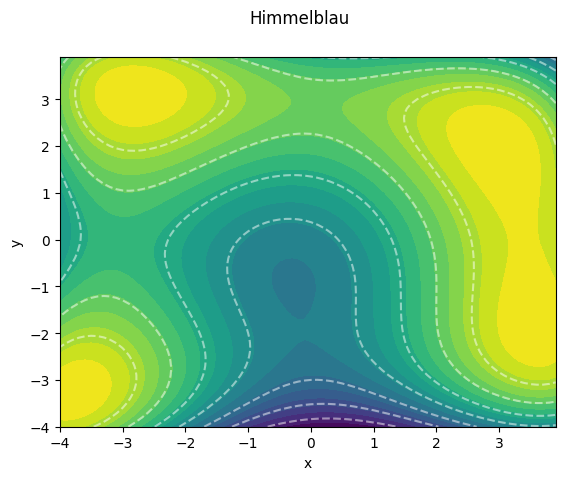

In [104]:
def himmelblau(x, y):
    return -((x**2 + y - 11)**2 + (x + y**2 - 7)**2)

def visulize_himmelblau():
    x = np.arange(-4, 4, 0.1)
    y = np.arange(-4, 4, 0.1)
    X, Y = np.meshgrid(x, y)
    Z = -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)

    fig = plt.figure('himmelblau')
    fig.suptitle('Himmelblau')
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap=plt.cm.viridis, levels=np.linspace(np.min(Z), 0, 20))
    ax.contour(X, Y, Z, colors='white', alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

visulize_himmelblau()

### 👩🏻‍🤝‍🧑🏼 Population visualization
The following function is used to plot the population of individuals in the search space. By uncommenting the `savefig` line, the plot will be saved in the `./images` folder to facilitate the creation of the gif.

In [126]:
def visualize_population(generation, population=None, parents=None, best_individual=None):
    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    X, Y = np.meshgrid(x, y)
    Z = -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)

    fig = plt.figure('himmelblau')
    fig.suptitle('Population Distribution')
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap=plt.cm.viridis, levels=np.linspace(np.min(Z), 9, 27))
    ax.contour(X, Y, Z, colors='white', alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    if population is not None:
        population_x = [ind[0] for ind in population]
        population_y = [ind[1] for ind in population]
        ax.scatter(population_x, population_y, color='orange', marker='o', label='Population', s=20)
    
    if parents is not None:
        parents_x = [ind[0] for ind in parents]
        parents_y = [ind[1] for ind in parents]
        ax.scatter(parents_x, parents_y, color='red', marker='o', label='Parents', s=20)
    
    if best_individual is not None:
        # use a star marker to denote the best individual
        ax.scatter(best_individual[0], best_individual[1], color='white', marker='*', 
            label='All-time best\nf({:.4f}, {:.4f}) = {:.4f}'.format(best_individual[0], best_individual[1], himmelblau(best_individual[0], best_individual[1])),
            s=100, edgecolors='black', linewidths=0.5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)
    
    info = []
    info.append('Global maxima:')
    info.append('1) f(3.0,2.0) = 0.0')
    info.append('2) f(-2.805118,3.131312) = 0.0')
    info.append('3) f(-3.779310,-3.283186) = 0.0')
    info.append('4) f(3.584428,-1.848126) = 0.0')

    plt.figtext(0.95, 0.45, '\n'.join(info), fontsize=10, va='bottom', ha='left', linespacing=1.5)
    # Save the image for animation
    # plt.savefig('population_evolution_{}.png'.format(generation))
    plt.show()


## [2] - Genetic Operators

### 🦠 Mutation - "Asexual breeding"
The **mutation operator** can be described as a stochastic process that makes small, random changes to one or more genes of an individual. These changes are introduced to create genetic diversity within a population of candidate solutions.

Objectives:
- Manteinance of `diversity` in the population
- Avoid `premature convergence` to a local optimum
- Favor `exploration` of the search space

Parameters:
- `mutation rate`: probability of mutation for each gene
- `mutation strength`: how much the gene is changed
- `mutation type`: type of mutation (e.g. uniform, gaussian, etc.)

Adjusting these parameters can influence the trade-off between exploration and exploitation in the search.

Since in this simplified example we only have two genes, representing the $x$ and $y$ coordinates, I've also defined a `pervasive mutation` operator that allows to change both genes at the same time.

In [118]:
def uniform_mutation(individual, p=0.1, dim=0.5):
    """
      Uniform mutation.
      - p: probability of mutating a gene
      - dim: the range of the mutation
    """
    # Create child
    child = np.empty_like(individual)
    for i in range(len(individual)):
        if random.random() < p:
            child[i] = individual[i]
        else:
            child[i] = individual[i] + random.uniform(-dim, dim)
    return child

def pervasive_uniform_mutation(individual, p=0.1, dim=0.5):
    """
        Uniform mutation.
        - p: probability of mutating ALL genes
    """
    
    # Create child
    child = np.empty_like(individual)
    if random.random() < p:
        for i in range(len(individual)):
            child[i] = individual[i] + random.uniform(-dim, dim)
    else:
        child = individual
    return child


def pervasive_gaussian_mutation(individual, p=0.1, mu=0, sigma=1):
    """
      Gaussian mutation.
      - p: probability of mutating ALL genes
      - mu: mean of the Gaussian distribution
      - sigma: standard deviation of the Gaussian distribution - the mutation strength
    """
    # Create child
    child = np.empty_like(individual)
    if random.random() < p:
        for i in range(len(individual)):
            child[i] = individual[i] + random.gauss(mu, sigma)
    else:
        child = individual
    return child

def gaussian_mutation(individual, p=0.1, mu=0, sigma=1):
    """
      Gaussian mutation.
      - p: probability of mutating a gene
      - mu: mean of the Gaussian distribution
      - sigma: standard deviation of the Gaussian distribution - the mutation strength
    """
    # Create child
    child = np.empty_like(individual)
    for i in range(len(individual)):
        if random.random() < p:
            child[i] = individual[i]
        else:
            child[i] = individual[i] + random.gauss(mu, sigma)
    return child


#### Adaptive mutation
Adaptive mutation in genetic algorithms refers to the ability to dynamically `adjust mutation rates and step sizes` during the optimization process. This adaptability is valuable in balancing exploration and exploitation in the search for the optimal solution.
1. `Self-adaptive mutation`: the mutation step size is encoded in the chromosome and evolves during the optimization process
2. `Stagnation-based mutation`: the mutation rate is adjusted based on the number of generations without improvement
3. `Cooling-based mutation`: the mutation rate decreases over time, favoring exploration in the early stages of the search and exploitation in the later stages

By now, I've only implemented a very simple form of `cooling-based mutation`, where the mutation rate is decreased linearly over time. Future improvements could include the implementation of more sophisticated adaptive mutation operators.

### 👨🏽‍👩🏻‍👧🏻‍👦🏽 Crossover - "sexual breeding"
The **crossover operator** is a fundamental genetic operator used in genetic algorithms (GAs) and other evolutionary algorithms. It plays a key role in generating new candidate solutions by combining information from two or more parent solutions to create one or more offspring solutions. Crossover simulates the genetic recombination process, which is inspired by biological reproduction.

Objectives:
- `Recombination` of genetic material
- Favor `exploitation` by preserving good genes

Parameters:
- `crossover rate`: probability of crossover for each gene
- `crossover type`: type of crossover (e.g. one-point, two-point, uniform, etc.)

Since in this simplified example we only have two genes, representing the $x$ and $y$ coordinates, I will use a static `one-point crossover` operator that swaps the genes of the two parents and an `arithmetic crossover` operator that creates a new individual by taking the average of the two parents.

In [107]:
def one_point_xover(ind1, ind2, p=1.0):
    """
      One-point crossover.
      - p: probability of crossover
    """
    # Create children
    child1, child2 = np.empty_like(ind1), np.empty_like(ind2)
    if random.random() < p:
        # Select crossover point
        #cxpoint = random.randint(1, len(ind1)-1)
        cxpoint = 1
        # Create children
        child1 = np.hstack((ind1[:cxpoint], ind2[cxpoint:]))
        child2 = np.hstack((ind2[:cxpoint], ind1[cxpoint:]))
    else:
        child1, child2 = ind1, ind2
    return child1, child2

def average_xover(parent1, parent2, p=1.0):
    """
      Average crossover.
      - Only suitable for real-valued representations (!)
      - p: probability of crossover
    """
    # Create children
    child1, child2 = np.empty_like(parent1), np.empty_like(parent2)
    if random.random() < p:
        for i in range(len(parent1)):
            child1[i] = (parent1[i] + parent2[i]) / 2
            child2[i] = (parent1[i] + parent2[i]) / 2
    else:
        child1, child2 = parent1, parent2
    return child1, child2

### 🏇🏻 Selection
The **selection operator** is a genetic operator used in genetic algorithms (GAs) to select potentially useful solutions for recombination. Selection simulates the natural selection process, where fitter individuals are more likely to be selected for reproduction in order to produce fitter offspring.

Objectives:
- Introduction of `deteminism` in the search
- `Fitness-based` selection of the best individuals
- Favor `exploitation` by preserving good genes

Parameters:
- `selection pressure`: how much the best individuals are favored
- `selection type`
  1. `fitness-proportionate selection`: each individual is selected with a probability proportional to its fitness
  2. `tournament selection`: a subset of individuals is randomly selected and the best one is chosen
  3. `rank-based selection`: each individual is selected with a probability proportional to its rank

Since the fitness function is the negative of Himmelblau's function, the best individuals are those with the lowest fitness value in absolute value (max fitness = 0). Due to the nature of the function, 'fitness-proportionate selection' would be a bad choice because it would favor the worst individuals. Therefore, I will use a simple `tournament selection` operator that selects the best individual among a random subset of the population.

In [108]:
def tournament_selection(population, fitness_values, tournament_size):
    """
      Tournament selection.
      - tournament_size: the number of individuals participating in the tournament
        - if tournament_size = 1 -> random selection
        - if tournament_size = pop_size -> elitism (best individual is selected)
    """
    winner_idx = random.randint(0, len(population)-1)
    for i in range(tournament_size-1):
        idx = random.randint(0, len(population)-1)
        if fitness_values[idx] > fitness_values[winner_idx]:
            winner_idx = idx
    return population[winner_idx]

### 🏋🏻 Problem specific functions


In [109]:
def initialize_population(population_size):
    return [(random.uniform(-4, 4), random.uniform(-4, 4)) for _ in range(population_size)]

def evaluate_population(population):
    return [himmelblau(x, y) for x, y in population]

## [3] - Simulation and Visualization

### 🎛️ Parameter Tuning
In genetic algorithms, the delicate balance between exploration and exploitation greatly influences the algorithm's performance. To achieve optimal results, it's crucial to understand and regulate specific parameters.

> By fine-tuning these parameters, we can tailor the algorithm's behavior to suit the characteristics of our optimization problem, ultimately enhancing its efficiency and effectiveness.

In [120]:
"""POPULATION"""
population_size = 100
generations = 10

"""EVOLUTION"""
mutation_rate = 0.3
  # 1: always mutate
mutation_strength = 0.5
  # sigma: in Gaussian mutation
  # dim: in uniform mutation
tournament_size = 2
  # 1: random selection
  # pop_size: elitism
cooling_rate = 1
  # decrease the mutation rate & strength after each generation
  # cooling_rate = 1: no cooling
crossover_rate = 1
  # 0: no crossover
  # 1: always crossover

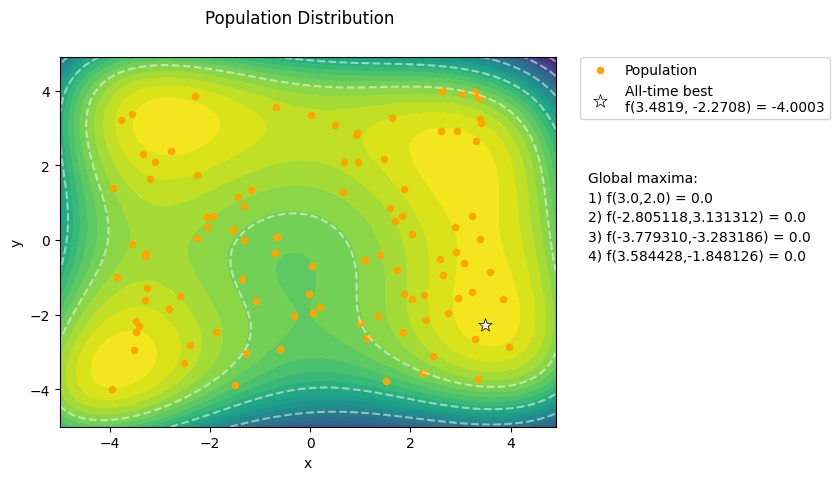

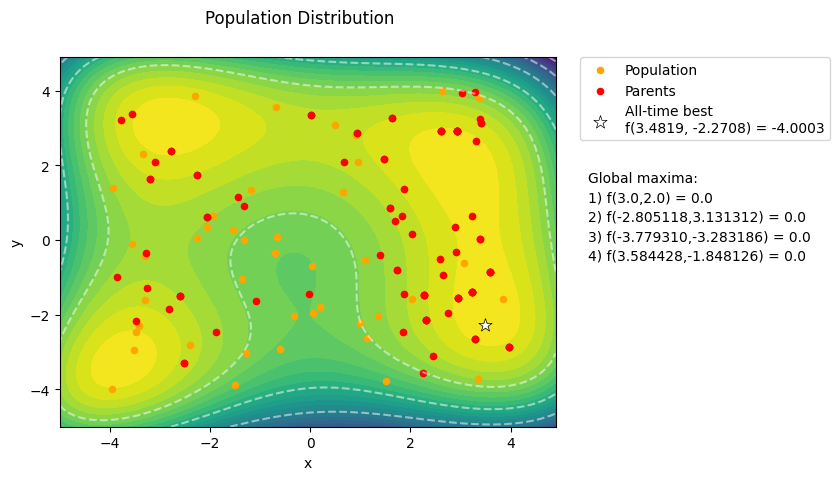

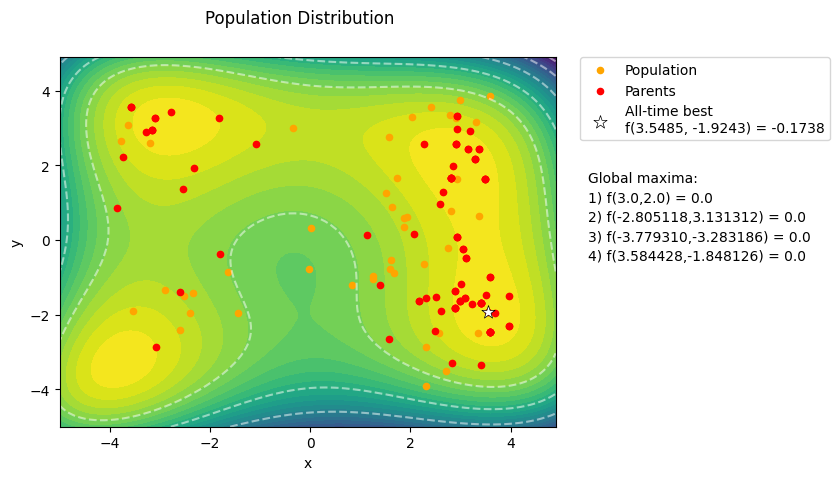

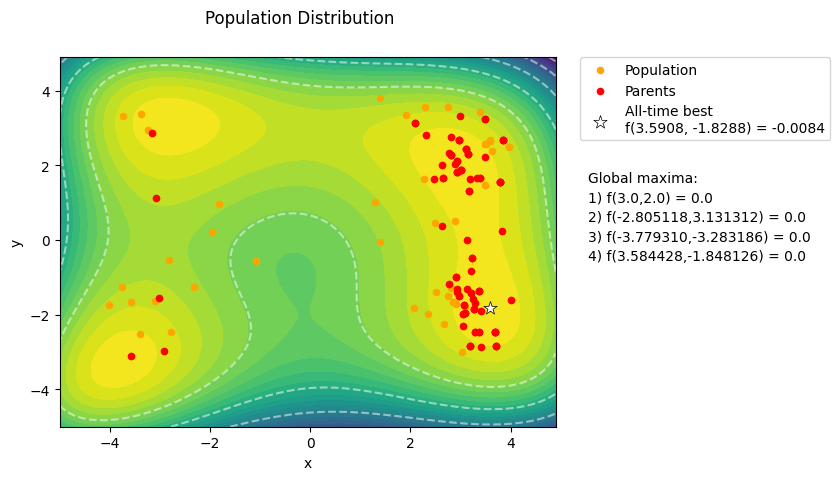

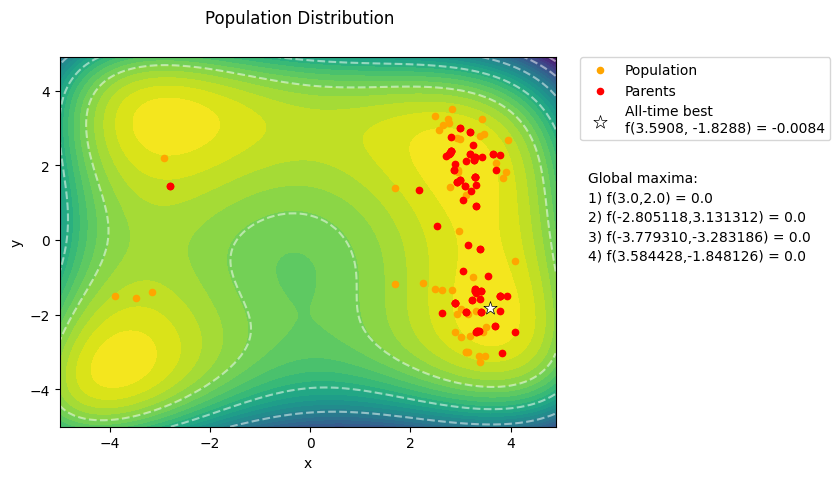

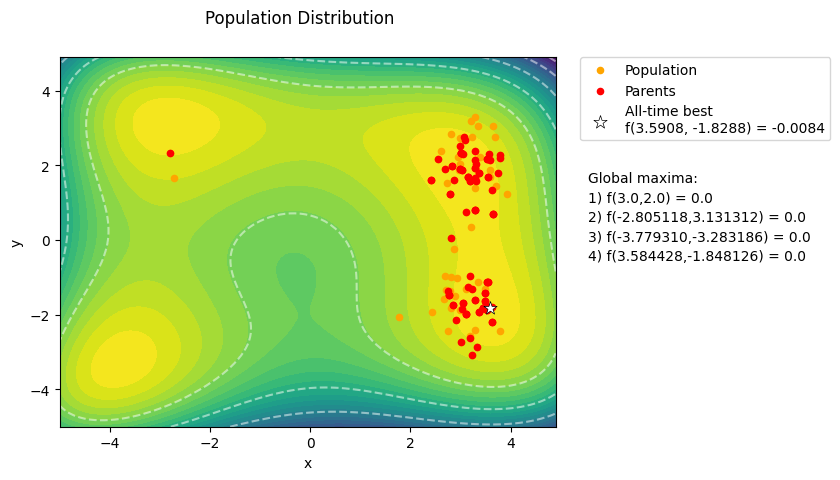

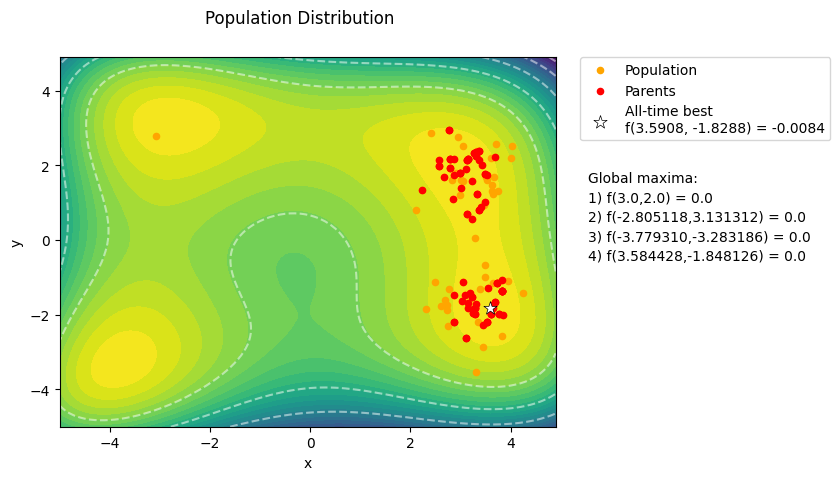

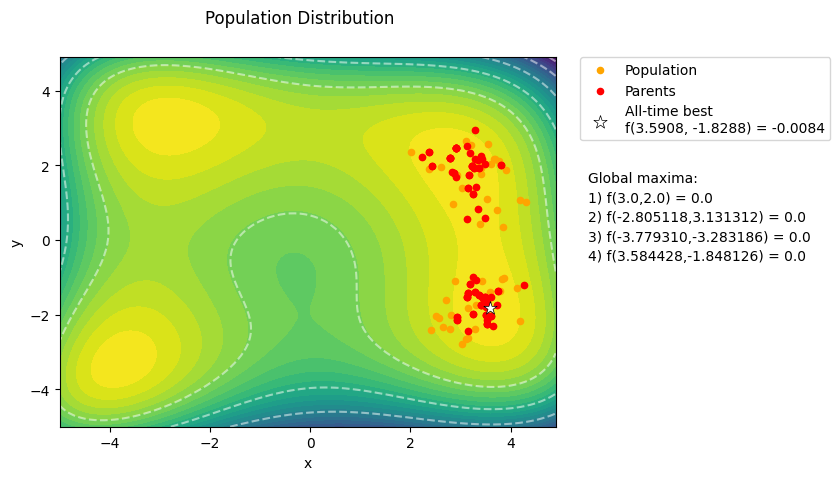

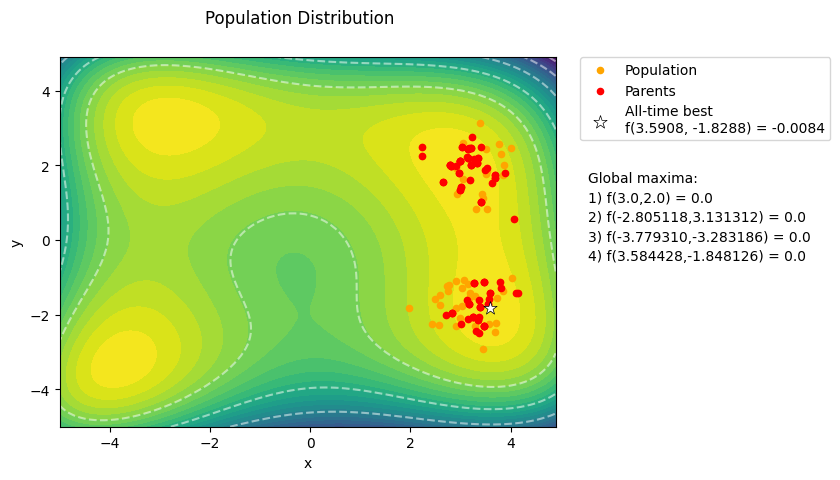

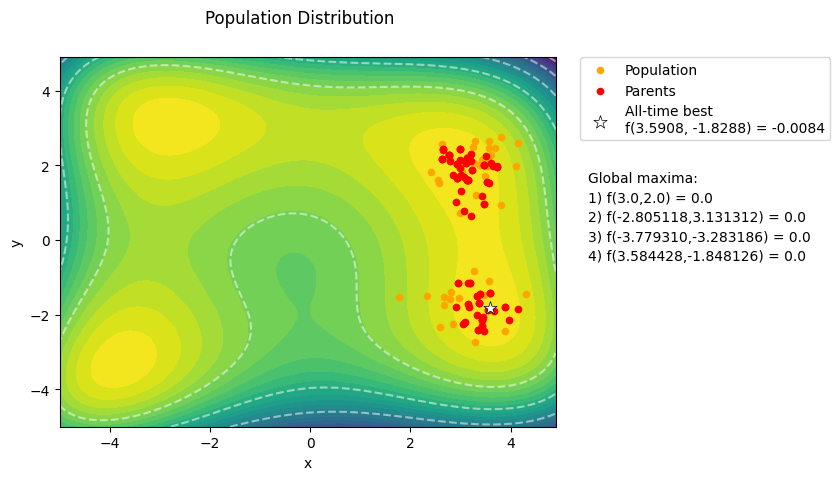

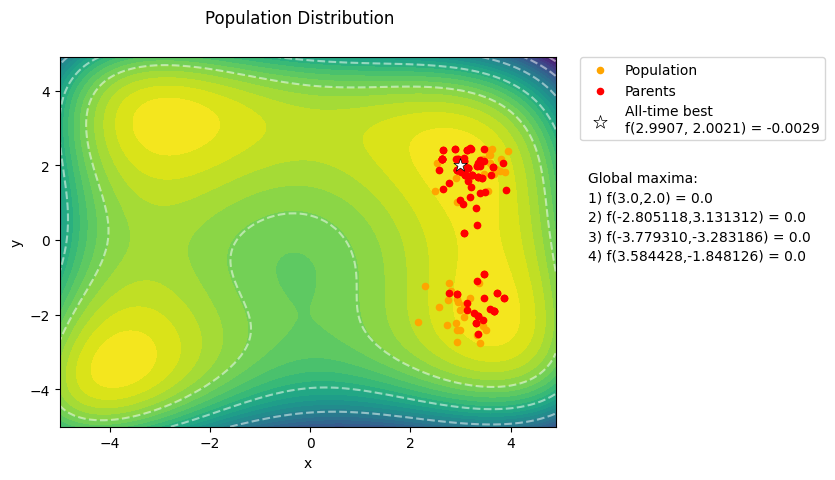

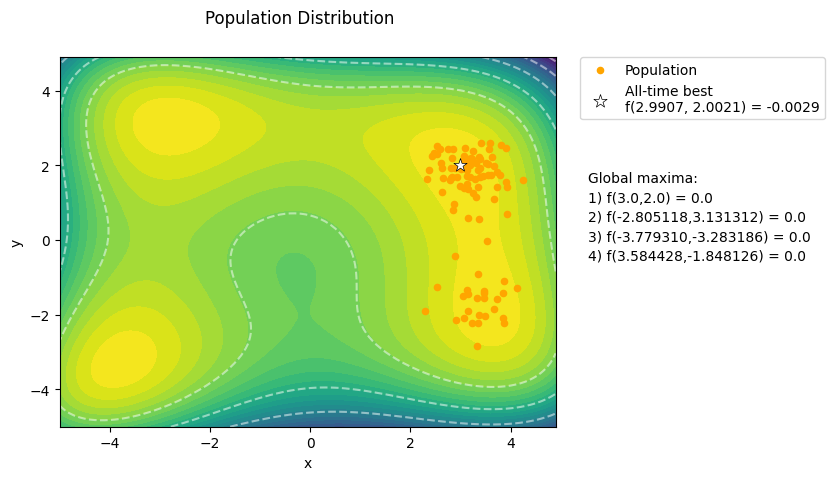

In [128]:
# Initialize population & all time best individual (to not lose it during evolution)
population = initialize_population(population_size)
all_time_best = max(population, key=lambda ind: himmelblau(ind[0], ind[1]))

# Visualize initial state
visualize_population(0, population, best_individual=all_time_best)

for generation in range(generations):

    fitness_values = evaluate_population(population)
    new_population = []
    parents = []
    for _ in range(population_size // 2):

        # Parents selection - SELECTION OPERATOR
        parent1 = tournament_selection(population, fitness_values, tournament_size)
        parent2 = tournament_selection(population, fitness_values, tournament_size)
        parents.extend([parent1, parent2])

        # Children generation - CROSSOVER OPERATOR + MUTATION OPERATOR
        if random.random() <= crossover_rate:
            child1, child2 = one_point_xover(parent1, parent2)
        child1 = uniform_mutation(child1, p=mutation_rate, dim=mutation_strength)
        child2 = uniform_mutation(child2, p=mutation_rate, dim=mutation_strength)
        new_population.extend([child1, child2])

    # Visualize current generation state
    visualize_population(generation+1, population, parents, all_time_best)

    # Adaptive mutation strength
    mutation_strength *= cooling_rate

    # Update population and best individual
    population = new_population
    current_best = max(population, key=lambda ind: himmelblau(ind[0], ind[1]))
    if himmelblau(current_best[0], current_best[1]) > himmelblau(all_time_best[0], all_time_best[1]):
        all_time_best = current_best

# Visualize final state
visualize_population(generations+1, population,best_individual=all_time_best)